In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from lstm_chem.utils.config import process_config
from lstm_chem.model import LSTMChem
from lstm_chem.generator import LSTMChemGenerator

In [2]:
CONFIG_FILE = 'experiments/2020-03-24/LSTM_Chem/config.json'
config = process_config(CONFIG_FILE)

In [3]:
modeler = LSTMChem(config, session='generate')

Loading model architecture from experiments/2020-03-24/LSTM_Chem/model_arch.json ...
Loading model checkpoint from experiments/2020-03-24/LSTM_Chem/checkpoints/LSTM_Chem-22-0.45.hdf5 ...
Loaded the Model.


In [4]:
# It took more than 4 hours!
generator = LSTMChemGenerator(modeler)
sampled_smiles = generator.sample(num=30000)

100%|██████████| 30000/30000 [4:23:30<00:00,  1.90it/s]  


In [5]:
from rdkit import RDLogger, Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
RDLogger.DisableLog('rdApp.*')

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


RDKit WARNING: [15:35:40] Enabling RDKit 2019.09.3 jupyter extensions


In [6]:
valid_mols = []
for smi in sampled_smiles:
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        valid_mols.append(mol)
# low validity
print(f'{len(valid_mols) / 30000:.2%}')

62.25%


In [7]:
valid_smiles = [Chem.MolToSmiles(mol) for mol in valid_mols]
# high uniqueness
print(f'{len(set(valid_smiles)) / len(valid_smiles):.2%}')

99.74%


In [8]:
with open('./datasets/dataset_cleansed.smi') as f:
    org_smiles = [l.rstrip() for l in f]

org_mols = [mol for mol in [Chem.MolFromSmiles(smi) for smi in org_smiles] if mol is not None]

In [9]:
Vfps = []
for mol in valid_mols:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Vfps.append(fp)

Ofps = []
for mol in org_mols:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Ofps.append(fp)

In [10]:
from sklearn.decomposition import PCA
Vlen = len(Vfps)
x = Vfps + Ofps
pca = PCA(n_components=2, random_state=71)
X = pca.fit_transform(x)

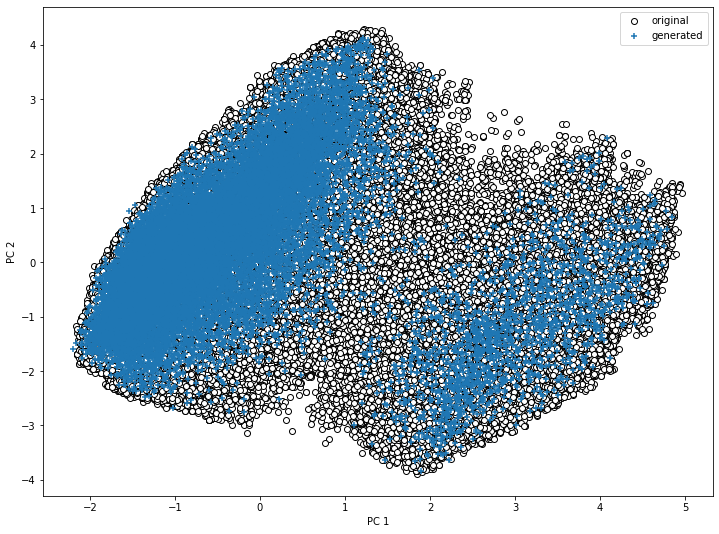

In [11]:
plt.figure(figsize=(12, 9))
plt.scatter(X[Vlen:, 0], X[Vlen:, 1], c='w', edgecolors='k', label='original')
plt.scatter(X[:Vlen, 0], X[:Vlen, 1], marker='+', label='generated')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend();

In [12]:
props = {
    'MW': {
        'generated': [Descriptors.ExactMolWt(mol) for mol in valid_mols],
        'original': [Descriptors.ExactMolWt(mol) for mol in org_mols]        
    },
    'logP': {
        'generated': [Descriptors.MolLogP(mol) for mol in valid_mols],
        'original': [Descriptors.MolLogP(mol) for mol in org_mols]
    }
}

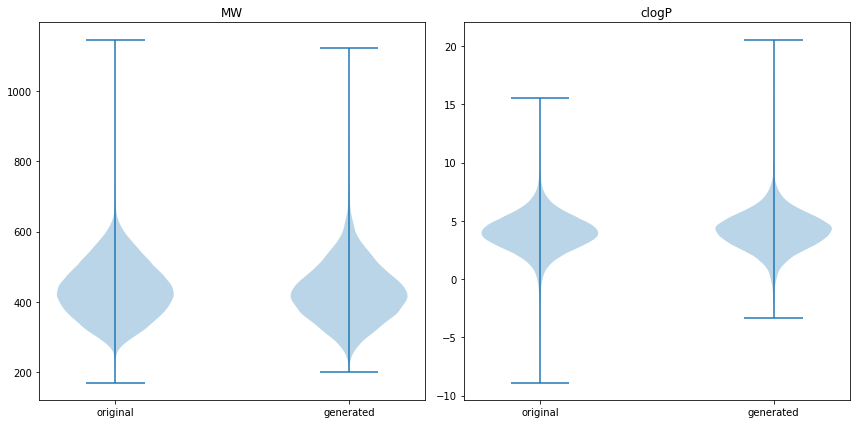

In [13]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(1, 2, 1)
ax1.violinplot([props['MW']['original'], props['MW']['generated']])
ax1.set_xticks(ticks=[1, 2])
ax1.set_xticklabels(labels=['original', 'generated'])
ax1.set_title('MW')

ax2 = fig.add_subplot(1, 2, 2)
ax2.violinplot([props['logP']['original'], props['logP']['generated']])
ax2.set_xticks(ticks=[1, 2])
ax2.set_xticklabels(labels=['original', 'generated'])
ax2.set_title('clogP')

plt.tight_layout()